<u>Imports</u>

In [1]:
# Standard
import pandas as pd
import numpy as np
import requests
from scipy.stats import randint

# Scrapping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.common.exceptions import TimeoutException

# Text processing
import re

# Dataset preparation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt

<u>Scrapping</u>

In [2]:
url = 'https://www.windguru.cz/112'
exec_path = '/Users/marionchaffaut/chromedriver/chromedriver-mac-x64/chromedriver' # Put as ENV
num_prev = 100 # Number of observations to be collected from Windguru

In [3]:
class Scraper:

    def __init__(self, url):
        self.url = url
        self.driver = webdriver.Chrome(executable_path=exec_path)
        self.driver.get(self.url)
        
    def scrape(self, num_prev):

        """
        Scrapes forecast data for a specified number of observations (1 observation = 2-hour period)
        Args:
        * num_prev: Number of forecast periods to scrape.
        Returns:
        * A pandas DataFrame containing the scraped forecast data:
            - Date & hour of estimate
            - Wind and gust speed and direction
            - Swell height, period and direction
        """ 

        # wait for the browsed page before scraping
        try:
            myElem = WebDriverWait(self.driver, 5).until(expected_conditions.presence_of_element_located((By.XPATH, '//*[@id="tabid_0_0_dates"]/td[1]')))
        except TimeoutException:
            None
        
        forecast = {}

        names_fig = ['tabid_0_0_dates','tabid_0_0_WINDSPD','tabid_0_0_GUST','tabid_0_0_HTSGW', 'tabid_0_0_PERPW']
        names_dir = ['tabid_0_0_SMER','tabid_0_0_DIRPW']
        
        for name in names_fig:
            temp_list = []
            for i in range(1, num_prev + 1):
                try:
                    value = self.driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]')
                    temp_list.append(value.text)
                except Exception as e:
                    temp_list.append('na')
            forecast[name] = temp_list

        for name in names_dir:
            temp_list = []
            for i in range(1, num_prev + 1):
                try:
                    value = self.driver.find_element(By.XPATH, f'//*[@id="{name}"]/td[{i}]/span')
                    temp_list.append(value.get_attribute('title'))
                except Exception as e:
                    temp_list.append('na')
            forecast[name] = temp_list
        
        forecast_df=pd.DataFrame(forecast)
        
        # Formatting 
        forecast_df.columns = ['date','wind_speed','gust_speed','swell_height','swell_period','wind_dir','swell_dir']
        forecast_df.wind_dir = forecast_df.wind_dir.apply(lambda x: int(re.search(r'\((\d+)°\)', x).group(1)) if re.search(r'\((\d+)°\)', x) else None)
        forecast_df.swell_dir = forecast_df.swell_dir.apply(lambda x: int(re.search(r'\((\d+)°\)', x).group(1)) if re.search(r'\((\d+)°\)', x) else None)
        forecast_df[['wind_speed', 'gust_speed', 'wind_dir', 'swell_dir', 'swell_period']] = forecast_df[['wind_speed', 'gust_speed', 'wind_dir', 'swell_dir', 'swell_period']].astype(int)
        forecast_df[['swell_height']] = forecast_df[['swell_height']].astype(float)
        forecast_df['wind_speed'] = forecast_df[['wind_speed', 'gust_speed']].mean(axis=1)
        forecast_df = forecast_df.drop(columns=['gust_speed'])
        
        return forecast_df

In [4]:
scraper = Scraper(url)

In [5]:
forecast_df = scraper.scrape(num_prev = 10)

In [6]:
forecast_df

,date,wind_speed,swell_height,swell_period,wind_dir,swell_dir
0,Mo\n1.\n07h,13.5,0.7,4,336,314
1,Mo\n1.\n09h,13.5,0.7,4,323,315
2,Mo\n1.\n11h,14.0,0.6,4,318,316
3,Mo\n1.\n13h,12.0,0.5,4,312,314
4,Mo\n1.\n15h,12.0,0.5,4,308,311
5,Mo\n1.\n17h,15.0,0.6,3,304,306
6,Mo\n1.\n19h,16.0,0.7,4,307,308
7,Mo\n1.\n21h,17.0,0.7,4,299,302
8,Tu\n2.\n03h,16.5,0.8,4,293,294
9,Tu\n2.\n05h,16.5,0.7,4,298,298


<u>Dataset preparation</u>

In [7]:
dataset = pd.read_excel('../data/dataset_rochebonne.xlsx')
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
dataset.head()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir,note
0,7,89,0.9,8,132,1
1,6,341,0.7,13,259,3
2,3,241,0.8,8,178,1
3,1,312,0.4,11,327,1
4,3,358,1.0,8,349,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wind_speed    688 non-null    int64  
 1   wind_dir      688 non-null    int64  
 2   swell_height  688 non-null    float64
 3   swell_period  688 non-null    int64  
 4   swell_dir     688 non-null    int64  
 5   note          688 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 32.4 KB


In [9]:
dataset.describe()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir,note
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,9.758721,182.747093,0.776017,9.068314,180.498547,1.540698
std,8.656971,101.026017,0.251674,2.510470,106.167496,1.134904
min,0.000000,0.000000,0.100000,1.000000,0.000000,0.000000
25%,4.000000,99.750000,0.600000,8.000000,89.750000,1.000000
50%,8.000000,177.000000,0.800000,9.000000,177.000000,2.000000
75%,13.000000,267.250000,0.900000,11.000000,273.000000,3.000000
max,40.000000,360.000000,1.800000,17.000000,359.000000,3.000000


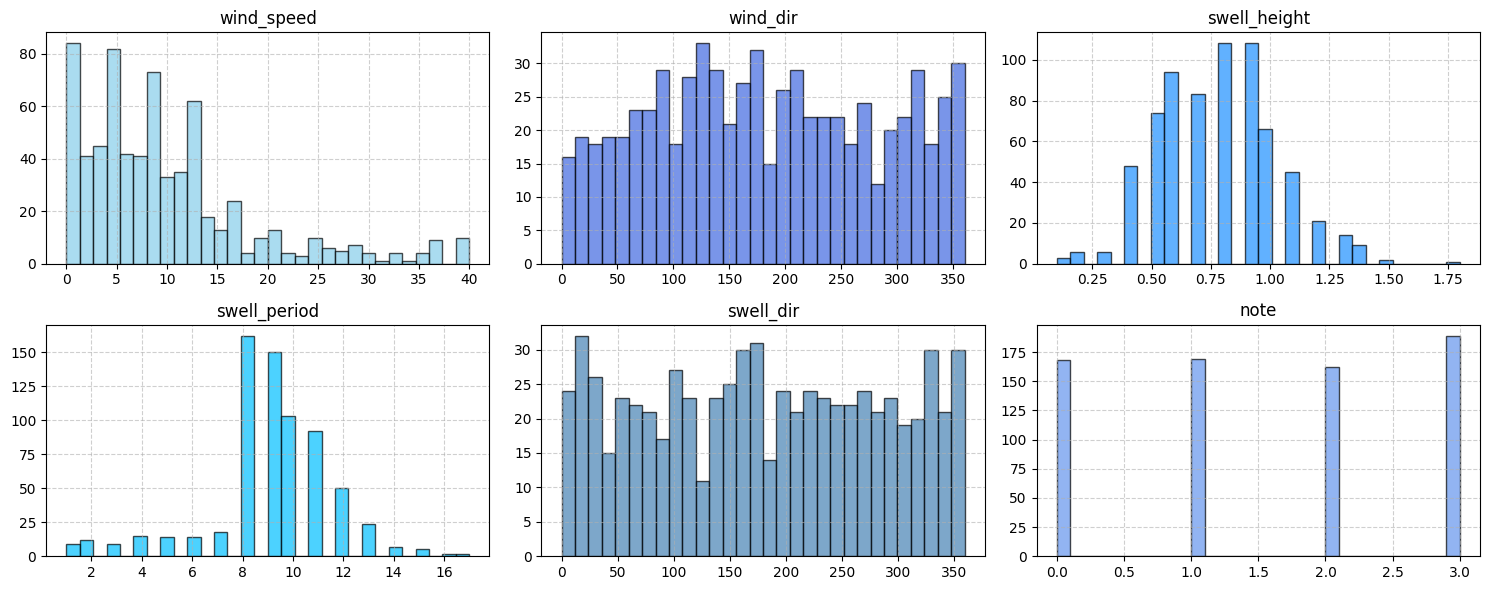

In [10]:
# Plot distribution

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
columns = ['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir', 'note']
colors = ['skyblue', 'royalblue', 'dodgerblue', 'deepskyblue', 'steelblue', 'cornflowerblue']

for ax, col, color in zip(axes.flatten(), columns, colors):
    ax.hist(dataset[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [11]:
dataset.note.value_counts()

note
3    189
1    169
0    168
2    162
Name: count, dtype: int64

In [12]:
# Split X and y

y = dataset['note']
X = dataset.drop(columns=['note'])

In [13]:
# Split test and train sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Scale data 

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.fit_transform(X_train[['wind_speed', 'wind_dir', 'swell_dir']])
X_test_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.transform(X_test[['wind_speed', 'wind_dir', 'swell_dir']])

X_train_scaled[['swell_height', 'swell_period']] = standard_scaler.fit_transform(X_train[['swell_height', 'swell_period']])
X_test_scaled[['swell_height', 'swell_period']] = standard_scaler.transform(X_test[['swell_height', 'swell_period']])

In [15]:
X_train_scaled.describe()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
count,550.000000,550.000000,5.500000e+02,5.500000e+02,550.000000
mean,0.248136,0.507192,4.198662e-17,1.647167e-16,0.502218
std,0.218253,0.281550,1.000910e+00,1.000910e+00,0.298442
min,0.000000,0.000000,-2.703513e+00,-3.236826e+00,0.000000
25%,0.100000,0.280556,-7.113746e-01,-4.301187e-01,0.245125
50%,0.200000,0.493056,8.548086e-02,-2.916059e-02,0.487465
75%,0.325000,0.738889,4.839086e-01,7.727557e-01,0.768106
max,1.000000,1.000000,2.874475e+00,3.178505e+00,1.000000


In [16]:
X_test_scaled.describe()

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
count,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.227355,0.509380,-0.050216,-0.008822,0.505026
std,0.208922,0.277932,1.012649,1.032609,0.285719
min,0.000000,0.025000,-2.305085,-3.236826,0.005571
25%,0.075000,0.265278,-0.711375,-0.430119,0.268802
50%,0.175000,0.484722,0.085481,-0.029161,0.532033
75%,0.300000,0.751389,0.483909,0.772756,0.726323
max,1.000000,0.983333,4.069758,2.777546,0.994429


<u>Modelling</u>

Comparison of the following:
- Logistic Regression,
- Decision Tree,
- Random Forest,
- KNN,
- XGBoost,
- Naïve Bayes,
- Support Vector Machines

In [17]:
accuracy = {} # Store the performance of each model

1- Logistic Regression

In [18]:
logistic_model = LogisticRegression(solver='newton-cg')

In [19]:
cv_results_log = cross_validate(logistic_model, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_log

{'fit_time': array([0.07300305, 0.01537895, 0.0098989 , 0.01332283, 0.01442575]),
 'score_time': array([0.00819778, 0.002635  , 0.0024941 , 0.00473213, 0.00304317]),
 'test_score': array([0.61818182, 0.67272727, 0.68181818, 0.7       , 0.65454545])}

In [20]:
accuracy['LogisticRegression'] = cv_results_log['test_score'].mean().round(2)

In [21]:
logistic_model.fit(X_train_scaled,y_train)

LogisticRegression(solver='newton-cg')

In [22]:
logistic_model.score(X_test_scaled,y_test)

0.6884057971014492

2- DecisionTreeClassifier

In [23]:
decision_tree = DecisionTreeClassifier()

In [24]:
cv_results_dt = cross_validate(decision_tree, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results_dt

{'fit_time': array([0.04635167, 0.00422597, 0.01381922, 0.00416303, 0.00647831]),
 'score_time': array([0.00323009, 0.00665998, 0.00313377, 0.00273895, 0.00355196]),
 'test_score': array([0.84545455, 0.82727273, 0.84545455, 0.83636364, 0.89090909])}

In [25]:
print(f'Average accuracy before RandomizedSearch: {cv_results_dt["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.849


In [26]:
accuracy['DecisionTree'] = cv_results_dt['test_score'].mean().round(2)

In [27]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [28]:
decision_tree.score(X_test,y_test)

0.8260869565217391

3- Random Forest

In [29]:
forest = RandomForestClassifier()

In [30]:
cv_results = cross_validate(forest, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results

{'fit_time': array([0.30583096, 0.24641299, 0.21949911, 0.24494505, 0.22545815]),
 'score_time': array([0.01243687, 0.00971818, 0.00973582, 0.00950408, 0.0095036 ]),
 'test_score': array([0.84545455, 0.86363636, 0.9       , 0.90909091, 0.88181818])}

In [31]:
print(f'Average accuracy before RandomizedSearch: {cv_results["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.88


In [32]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Perform randomized search for hyperparameter tuning

param_grid_forest = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)], # Number of trees
                'max_features': ['log2', 'sqrt', None], # Number of features at every split
                'max_depth': [None,1,2,4,6,8,10], # Maximum number of levels in tree
                'min_samples_split': [2,3,4,5], # Minimum number of samples to split a node
                'min_samples_leaf': [1, 2], # Minimum number of samples at each leaf node
                'bootstrap': [True, False]} # Method of selecting samples for growing each tree

forest_search = RandomizedSearchCV(estimator = forest, 
                                   param_distributions = param_grid_forest, 
                                   scoring='accuracy', 
                                   n_iter = 100, 
                                   cv = 5, 
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = -1)

forest_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 1, 2, 4, 6, 8, 10],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [10, 22, 34, 46, 58, 71,
                                                         83, 95, 107, 120]},
                   random_state=42, scoring='accuracy', verbose=1)

In [34]:
forest_best = forest_search.best_estimator_

In [35]:
cv_results_optimized = cross_validate(forest_best, X_train, y_train, scoring = 'accuracy', cv=5)
cv_results_optimized

{'fit_time': array([0.4244771 , 0.44258809, 0.49856114, 0.30665898, 0.27831984]),
 'score_time': array([0.0158    , 0.01348686, 0.01060462, 0.01096773, 0.01070189]),
 'test_score': array([0.85454545, 0.87272727, 0.9       , 0.9       , 0.89090909])}

In [36]:
forest_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=120)

In [37]:
y_pred = forest_best.predict(X_test)

In [38]:
print(f'Average accuracy after RandomizedSearch: {cv_results_optimized["test_score"].mean().round(2)}')

Average accuracy after RandomizedSearch: 0.88


In [39]:
target_names = ['rating 0', 'rating 1', 'rating 2', 'rating 3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    rating 0       1.00      0.94      0.97        33
    rating 1       0.83      0.83      0.83        35
    rating 2       0.85      0.88      0.87        33
    rating 3       0.97      1.00      0.99        37

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



In [40]:
accuracy['RandomForest'] = cv_results_optimized["test_score"].mean().round(2)

In [41]:
forest_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=120)

In [42]:
forest_best.score(X_test,y_test)

0.9202898550724637

4- KNeighbors

In [43]:
knn = KNeighborsClassifier()

In [44]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [45]:
cv_results_knn = cross_validate(knn, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_knn

{'fit_time': array([0.0427711 , 0.00436497, 0.00282407, 0.00289798, 0.0028801 ]),
 'score_time': array([0.01887512, 0.00725794, 0.00757289, 0.00745177, 0.00778008]),
 'test_score': array([0.67272727, 0.77272727, 0.72727273, 0.70909091, 0.79090909])}

In [46]:
print(f'Average accuracy before RandomizedSearch: {cv_results_knn["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.735


In [47]:
# Grid search for hyperparameter tuning

param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13], # Number of neighbours
              'weights': ['uniform', 'distance'], # Weight function used / uniform weights or relative to their distance
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorithm used to compute the nearest neighbors
              'p': [1, 2] # 1 = manhattan_distance, 2 = euclidean_distance
             }

knn_search = GridSearchCV(estimator = knn, 
                            param_grid = param_grid_knn, 
                            scoring='accuracy', 
                            cv = 5, 
                            verbose=1, 
                            n_jobs = -1)

knn_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [48]:
knn_best = knn_search.best_estimator_

In [49]:
cv_results_knn_best = cross_validate(knn_best, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_knn_best

{'fit_time': array([0.00467587, 0.00315118, 0.00289607, 0.00316787, 0.00295711]),
 'score_time': array([0.00988889, 0.0083909 , 0.00752091, 0.00831938, 0.00810218]),
 'test_score': array([0.69090909, 0.82727273, 0.74545455, 0.76363636, 0.8       ])}

In [50]:
print(f'Average accuracy after RandomizedSearch: {cv_results_knn_best["test_score"].mean().round(3)}')

Average accuracy after RandomizedSearch: 0.765


In [51]:
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier()

In [52]:
knn.score(X_test_scaled,y_test)

0.7391304347826086

5- XGBoost

In [53]:
xgb_model = XGBClassifier(objective='multi:softprob')

In [54]:
cv_results_xgb = cross_validate(xgb_model, X_train_scaled, y_train, scoring = 'accuracy', cv=5)
cv_results_xgb

{'fit_time': array([0.45555687, 0.14861894, 0.15306091, 0.19051504, 0.28247619]),
 'score_time': array([0.01280713, 0.00609279, 0.00569701, 0.00577807, 0.00659394]),
 'test_score': array([0.9       , 0.88181818, 0.91818182, 0.93636364, 0.86363636])}

In [55]:
print(f'Average accuracy before RandomizedSearch: {cv_results_xgb["test_score"].mean().round(3)}')

Average accuracy before RandomizedSearch: 0.9


In [56]:
# Perform randomized search for hyperparameter tuning

xgb_params = {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)],
            'max_depth' : [None, 1, 2, 4, 6, 8, 10],
            'min_child_weight': [None, 1, 5, 10]
        }

xgb_search = GridSearchCV(estimator = xgb_model, 
                                   param_grid = xgb_params, 
                                   scoring='accuracy', 
                                   cv = 5, 
                                   verbose=1, 
                                   n_jobs = -1)

xgb_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 4, 6, 8, 10],
                         'min_child_weight': [None, 1, 5, 10],
                         'n_estimators': [10, 22, 34, 46, 58, 71, 83, 95, 107,
                                          120]},
             scoring='accuracy', verbose=1)

In [57]:
xgb_best = xgb_search.best_estimator_

In [58]:
cv_results_xgb_best = cross_validate(xgb_best, X_train_scaled, y_train, scoring = 'accuracy', cv=5)

In [59]:
xgb_best.score(X_test_scaled,y_test)

0.8985507246376812

In [60]:
print(f'Average accuracy after RandomizedSearch: {cv_results_xgb_best["test_score"].mean().round(3)}')

Average accuracy after RandomizedSearch: 0.918


<u>Forecasts</u>

In [61]:
X_new_values = forecast_df[['wind_speed', 'wind_dir', 'swell_height', 'swell_period', 'swell_dir']]

In [62]:
y_new_values = forest_best.predict(X_new_values)

In [63]:
X_new_values

,wind_speed,wind_dir,swell_height,swell_period,swell_dir
0,13.5,336,0.7,4,314
1,13.5,323,0.7,4,315
2,14.0,318,0.6,4,316
3,12.0,312,0.5,4,314
4,12.0,308,0.5,4,311
5,15.0,304,0.6,3,306
6,16.0,307,0.7,4,308
7,17.0,299,0.7,4,302
8,16.5,293,0.8,4,294
9,16.5,298,0.7,4,298


In [64]:
X_new_values_scaled = X_new_values.copy()

In [65]:
X_new_values_scaled[['wind_speed', 'wind_dir', 'swell_dir']] = minmax_scaler.transform(X_new_values[['wind_speed', 'wind_dir', 'swell_dir']])
X_new_values_scaled[['swell_height', 'swell_period']] = standard_scaler.transform(X_new_values[['swell_height', 'swell_period']])

In [66]:
y_new_values = xgb_best.predict(X_new_values_scaled)

In [67]:
y_new_values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
forecast_df['note'] = y_new_values